# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import time
import numpy as np
import pandas as pd
import random
import re
from timeit import default_timer as timer

from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.externals import joblib
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, learning_curve

import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

/Users/liliyajeromin/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

# Outlines

## Part 1: Customer Segmentation Report

**1.1 Define all functions that will be used in this project**

**1.2 Preprocessing of population dataset**

    1.2.1 Load data and fix problems
    1.2.2 Assess unknown data in columns and rows, and replace them with NaN
    1.2.3 Remove columns with more than 30% missing values and rows with more than 20% of missing values
    1.2.4 Re-engineer features
    1.2.5 Re-encode object features
    1.2.6 Build a cleaning function for cleaning customer data
    
**1.3 Primary component analysis (PCA) and K-means clustering of population dataset**
    
    1.3.1 Imputation, feature selection and scaling
    1.3.2 Apply PCA
    1.3.3 Apply K-means clustering

**1.4 Apply the same procedure on Customer datasest**
**1.5 Compare customer cluster to population cluster and obtain the demographic characteristics of potential customers**

## Part 2: Supervised Learning Model

**2.1 Define all functions that will be used in this project**
**2.2 Split data into training and testing data**
**2.3 Select classifers and train models with default parameters**
**2.4 Fine tune parameters**

    2.4.1 Fine tune parameters for XGBRegressor
    2.4.2 Fine tune parameters for GradientBoostingRegressor

**Part 1: Customer Segmentation Report**

1.1 Define all functions that will be used in this project

In [2]:
#handy method to remove columns
def remove_col (df, cols):
    '''
    Romoves list of columns (cols) you don't need from the df.
    
    INPUT:
    df - pandas dataframe from which you want to delete columns.
    cols - list of strings that are associated with names of columns you want to delete.
    
    OUTPUT:
    df - a new dataframe without columns you deleted.
          
    '''
    for col in cols:
        df = df.drop(columns=col, axis=1)
    return df

In [3]:
#handy method categorical variables to dummies
def cat_var(df):
    '''
    Turning categorical variables into dummies.
    
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy.
    cat_vars - list of strings that are associated with names of the categorical columns.
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical.
            2. removes all the original columns in cat_vars.
            3. dummy columns for each of the categorical columns in cat_vars.
            4. Use a prefix of the column name with an underscore (_) for separating. 
    '''
    
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    return df

In [4]:
def fill_na(df, col):
    '''
    Fill in the blank cell with the last valid observation
    
    Keyword arguments:
    df: dataframe
    col: column name
    
    Returns:
    dataframe with filled value
    
    '''
    df[col].fillna(method = 'ffill', inplace = True)
    return df

In [5]:
#filling NaNs
def num_var(df):
    '''
    Filling nulls with means of a column.
    
    INPUT:
    df - pandas dataframe with numerical columns you want to fill nulls into.
    num_vars - list of strings that are associated with names of the numerical columns.
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that are not numerical.
            2. contains all columns that didn't have NaNs.
            3. contains columns that had NaNs wit means instead .
    '''
    
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
    
    return df

In [6]:
# check values in azdias to see if there are abnormal values that were not defined in the feature_info table and replace it to NaN
def replace_no_meaning_value_with_nan(data, feature_doc):
    '''
    replace values in data sheet that were not described in the feature information spreadsheet with NaN
    
    Keyword arguments:
    data: data record
    feature_doc: feature information spreadsheet
    
    Returns:
    data with no meaning values replaced by NaN
    
    '''
    attribute_in_data = list(data.columns)
    attribute_in_feature = list(feature_doc['Attribute'].unique())
    shared_attribute = [value for value in attribute_in_data if value in attribute_in_feature]
    
    for attribute in shared_attribute:
        tempDf = data[[attribute]].dropna(axis=0)
        unique_values_in_data = set(tempDf[attribute])
        values_described_in_feature = set(feature_doc.loc[feature_doc.Attribute == attribute, 'Value'])
        values_no_meaning = list(unique_values_in_data - values_described_in_feature)
        if len(values_no_meaning) == 0:
            continue
        data[attribute] = data[attribute].apply(lambda x: np.nan if x in values_no_meaning else x)
        
    return data

In [7]:
# Identify missing or unknown data values documented in feature_info table and convert them to NaNs.
def replace_unknown_value_with_nan(data, feature_doc):
    '''
    Find unknown values in data sheet that were defined in the feature information spreadsheet and replace them with NaN
    
    Keyword arguments:
    data: data sheet
    feature_doc: feature information spreadsheet
    
    Returns:
    data with unknown values replaced by NaN
    
    '''
    #cols = data.columns.values
    cols = data.columns

    for colName in cols:
        na_values=feature_doc[(feature_doc.Attribute == colName) & (feature_doc.Meaning.str.contains('unknown|no transactions known'))].Value.tolist()   
        data[colName] = data[colName].apply(lambda x: np.nan if x in na_values else x)
        
    return data

In [8]:
#Once we find the columns we need to remove from azdias dataset, we need to remove the same columns from the 
#other datasets, such as the customer dataset; we also need to rows with more than 30 of missing values
def remove_columns_rows_by_NA_counts(data, azdias_rm_col):
    '''
    Remove the same columns from the customer dataset as we did in azdias; Rmoeve rows with more than 30 missing values
    
    Keyword arguments:
    data: data sheet
    azdias_rm_col: columns removed from azdias dataset
    
    Returns:
    data with columns and rows cleaned
    '''
    
    #drop the same columns as we did in azdias0.2]
    data_column_filtered = data.drop(azdias_rm_col, axis=1) 
    naCounts_by_row = data_column_filtered.isnull().sum(axis=1)
    data_column_filtered['naPercentage_by_row'] = naCounts_by_row/data_column_filtered.shape[1]
    data_column_row_filtered = data_column_filtered[data_column_filtered['naPercentage_by_row'] < 0.2] #extract rows with less than 30 missing data for further analysis
    data_column_row_filtered = data_column_row_filtered.drop('naPercentage_by_row', axis = 1)

    return data_column_row_filtered

In [9]:
#"CAMEO_INTL_2015" and "PRAEGENDE_JUGENDJAHRE" features contain two types of information, so we split the columns
# to two columns
def split_CAMEO_INTL_2015(data):
    '''
    Split "CAMEO_INTL_2015" feature into two columns
    
    Keyword arguments:
    data: data sheet

    Returns:
    data with "CAMEO_INTL_2015" feature splited into "CAMEO_INTL_2015_wealth" and "CAMEO_INTL_2015_life" columns
    '''
    
    CAMEO_INTL_2015_wealth = []
    CAMEO_INTL_2015_life = []
    for row in data['CAMEO_INTL_2015']:
        if math.isnan(float(row)):
            CAMEO_INTL_2015_wealth.append(np.nan)
            CAMEO_INTL_2015_life.append(np.nan)
        else:
            CAMEO_INTL_2015_wealth.append(int(int(row)/10))
            CAMEO_INTL_2015_life.append(int(row)%10)

    data['CAMEO_INTL_2015_wealth'] = CAMEO_INTL_2015_wealth
    data['CAMEO_INTL_2015_life'] = CAMEO_INTL_2015_life

    data.drop(['CAMEO_INTL_2015'], axis=1, inplace = True)

In [10]:
def split_PRAEGENDE_JUGENDJAHRE(data):
    '''
    Split "PRAEGENDE_JUGENDJAHRE" feature into two columns
    
    Keyword arguments:
    data: data sheet

    Returns:
    data with "PRAEGENDE_JUGENDJAHRE" feature splited into "PRAEGENDE_JUGENDJAHRE_decade" and "PRAEGENDE_JUGENDJAHRE_movement" columns
    '''
    PRAEGENDE_JUGENDJAHRE_decade = []

    for row in data['PRAEGENDE_JUGENDJAHRE']:
        if row in [1, 2]:
            PRAEGENDE_JUGENDJAHRE_decade.append(1)
        elif row in [3, 4]:
            PRAEGENDE_JUGENDJAHRE_decade.append(2)
        elif row in [5, 6, 7]:
            PRAEGENDE_JUGENDJAHRE_decade.append(3)
        elif row in [8, 9]:
            PRAEGENDE_JUGENDJAHRE_decade.append(4)    
        elif row in [10, 11, 12, 13]:
            PRAEGENDE_JUGENDJAHRE_decade.append(5)
        elif row in [14, 15]:
            PRAEGENDE_JUGENDJAHRE_decade.append(6)
        else:
            PRAEGENDE_JUGENDJAHRE_decade.append(np.nan)

    data['PRAEGENDE_JUGENDJAHRE_decade'] = PRAEGENDE_JUGENDJAHRE_decade

    PRAEGENDE_JUGENDJAHRE_movement = []
    for row in data['PRAEGENDE_JUGENDJAHRE']:
        if row in [1, 3, 5, 8, 10, 12, 14]:
            PRAEGENDE_JUGENDJAHRE_movement.append(0)
        elif row in [2, 4, 6, 7, 9, 11, 13, 15]:
            PRAEGENDE_JUGENDJAHRE_movement.append(1)
        else:
            PRAEGENDE_JUGENDJAHRE_movement.append(np.nan)
 
    data['PRAEGENDE_JUGENDJAHRE_movement'] = PRAEGENDE_JUGENDJAHRE_movement
    
    PRAEGENDE_JUGENDJAHRE_nation = []
    for row in data['PRAEGENDE_JUGENDJAHRE']:
        if row in [1, 2, 3, 4, 5, 8, 9, 14, 15]:
            PRAEGENDE_JUGENDJAHRE_nation.append(0)
        elif row in [7, 12, 13]:
            PRAEGENDE_JUGENDJAHRE_nation.append(1)
        else:
            PRAEGENDE_JUGENDJAHRE_nation.append(2)
 
    data['PRAEGENDE_JUGENDJAHRE_nation'] = PRAEGENDE_JUGENDJAHRE_nation

    data.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)


In [11]:
# Some values in "LP_STATUS_GROB" and "LP_FAMILIE_GROB" features have the same meaning, so these two functions 
#are to combine values with the same meaning to one value in these two features.
def engineer_LP_STATUS_GROB(data):
    '''
    Engineer "LP_STATUS_GROB" to combine values with the same meaning
    
    Keyword arguments:
    data: data sheet

    Returns:
    data with "LP_STATUS_GROB" feature re-engineered
    '''
    
    LP_STATUS_GROB_engineered = []

    for row in data['LP_STATUS_GROB']:
        if row in [1, 2]:
            LP_STATUS_GROB_engineered.append(1)
        elif row in [3, 4, 5]:
            LP_STATUS_GROB_engineered.append(2)
        elif row in [6, 7]:
            LP_STATUS_GROB_engineered.append(3)
        elif row in [8, 9]:
            LP_STATUS_GROB_engineered.append(4)
        elif row in [10]:
            LP_STATUS_GROB_engineered.append(5)
        else:
            LP_STATUS_GROB_engineered.append(np.nan)

    data['LP_STATUS_GROB_engineered'] = LP_STATUS_GROB_engineered
    data.drop(['LP_STATUS_GROB'], axis=1, inplace=True)

In [12]:
def engineer_LP_FAMILIE_GROB(data):
    '''
    Engineer "LP_FAMILIE_GROB" to combine values with the same meaning
    
    Keyword arguments:
    data: data sheet

    Returns:
    data with "LP_FAMILIE_GROB" feature re-engineered
    '''
    LP_FAMILIE_GROB_engineered = []

    for row in data['LP_FAMILIE_GROB']:
        if row in [3, 4, 5]:
            LP_FAMILIE_GROB_engineered.append(3)
        elif row in [6, 7, 8]:
            LP_FAMILIE_GROB_engineered.append(4)
        elif row in [9, 10, 11]:
            LP_FAMILIE_GROB_engineered.append(5)
        else:
            LP_FAMILIE_GROB_engineered.append(row)

    data['LP_FAMILIE_GROB_engineered'] = LP_FAMILIE_GROB_engineered
    data.drop(['LP_FAMILIE_GROB'], axis=1, inplace=True)

In [13]:
def histogram_plot(df):
    '''
    plot histogram
    
    Keyword arguments:
    df: data sheet

    Returns:
    histogram plot
    '''
    
    fig = df.hist(bins=10, figsize = (20,10))
    params = {'axes.titlesize':'6',
              'xtick.labelsize':'6',
              'ytick.labelsize':'6'}
    matplotlib.rcParams.update(params)
    plt.show()

In [14]:
def waitForSecs(secs):
    for i in range(1, secs):
        time.sleep(1)

In [15]:
#remove columns that have correlation higher than 0.9
#corr = azdias_nan_filled.corr()
def remove_high_correlated_columns(corr, data):
    columns = np.full((corr.shape[0],), True, dtype=bool)
    for i in range(corr.shape[0]):
        for j in range(i+1, corr.shape[0]):
            if corr.iloc[i,j] >= 0.9:
                if columns[j]:
                    columns[j] = False
    low_correlated_columns = data.columns[columns]
    data = data[low_correlated_columns]

    return data

**1.2 Preprocessing of population dataset**

In [16]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv')

/Users/liliyajeromin/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
azdias

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,891216,825761,-1,5.0,17.0,NaN,NaN,NaN,NaN,17.0,...,2.0,4.0,7.0,8.0,3.0,4.0,3.0,4,2,3
891217,891217,825771,-1,9.0,16.0,NaN,NaN,NaN,NaN,16.0,...,4.0,6.0,9.0,6.0,6.0,9.0,5.0,6,1,2
891218,891218,825772,-1,1.0,17.0,NaN,NaN,NaN,NaN,17.0,...,2.0,7.0,10.0,8.0,NaN,5.0,7.0,4,2,2
891219,891219,825776,-1,9.0,0.0,17.0,NaN,NaN,NaN,20.0,...,4.0,9.0,8.0,5.0,1.0,9.0,5.0,5,1,1


In [18]:
#Unnamed seems to be an index column
azdias.drop('Unnamed: 0', axis=1, inplace=True)

In [19]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [20]:
azdias.isna().sum()

LNR                          0
AGER_TYP                     0
AKT_DAT_KL               73499
ALTER_HH                 73499
ALTER_KIND1             810163
                         ...  
WOHNDAUER_2008           73499
WOHNLAGE                 93148
ZABEOTYP                     0
ANREDE_KZ                    0
ALTERSKATEGORIE_GROB         0
Length: 366, dtype: int64

In [21]:
#column 18 and 19 have mixed values, check the values and fix the problem.
print(azdias.iloc[:,18].value_counts())
print(azdias.iloc[:,19].value_counts())

8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X        373
Name: CAMEO_DEUG_2015, dtype: int64
51      77576
51.0    56118
41      53459
24      52882
41.0    38877
24.0    38276
14      36524
43      32730
14.0    26360
54      26207
43.0    23942
25      22837
54.0    19184
22      19173
25.0    16791
23      15653
13      15272
45      15206
22.0    13982
55      13842
52      11836
23.0    11097
13.0    11064
31      11041
45.0    10926
34      10737
55.0    10113
15       9832
52.0     8706
44       8543
31.0     7983
34.0     7787
12       7645
15.0     7142
44.0     6277
35       6090
32       6067
33       5833
12.0     5604
32.0     4287
35.0     4266
33.0     4102
XX        373
Name: CAMEO_INTL_2015, dtype: int64


In [22]:
# replace "x", "xx" with NaN, and set the data type to float
COL_CAMEO_DEUG_2015 = 'CAMEO_DEUG_2015'
COL_CAMEO_INTL_2015 = 'CAMEO_INTL_2015'

azdias[COL_CAMEO_DEUG_2015] = azdias[COL_CAMEO_DEUG_2015].astype(str).replace({'X':np.nan}).astype(float)
azdias[COL_CAMEO_INTL_2015] = azdias[COL_CAMEO_INTL_2015].astype(str).replace({'XX':np.nan}).astype(float)

# Drop column 'LNR'
azdias.drop(['LNR'], axis=1, inplace=True)

In [23]:
#read in feature spreadsheet, these two sheets are multi-level indexed, so use fill_na function to fill the blank cells
attributes_describe = pd.read_excel('./DIAS Information Levels - Attributes 2017.xlsx',header = 1, usecols = range(1,5))
attributes_describe = fill_na(attributes_describe, 'Information level')

feature_info = pd.read_excel('./DIAS Attributes - Values 2017.xlsx', header = 1, usecols = range(1,6))
feature_info = fill_na(feature_info, 'Attribute')
feature_info = fill_na(feature_info, 'Description')

In [24]:
print(attributes_describe.shape)
attributes_describe.head()

(313, 4)


,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,Person,ANREDE_KZ,gender,NaN
3,Person,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,Person,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [25]:
print(feature_info.shape)
feature_info

(2258, 4)


,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
...,...,...,...,...
2253,ZABEOTYP,typification of energy consumers,2,smart
2254,ZABEOTYP,typification of energy consumers,3,fair supplied
2255,ZABEOTYP,typification of energy consumers,4,price driven
2256,ZABEOTYP,typification of energy consumers,5,seeking orientation


In [26]:
feature_info.Attribute.nunique()

314

In [27]:
# there are 313 attributes in the feature_info spreadsheet, but 366 in the azdias population, so there is inconsistent 
#between the azdias and feature_info spreadsheet
attributes_not_documented_in_feature_info = list(set(list(azdias.columns)) - set(list(attributes_describe['Attribute'])))
attributes_no_data_in_azdias =list(set(list(attributes_describe['Attribute'])) - set(list(azdias.columns)))

print('attributes that are included in azdias dataset, but not in attributes spreadsheet:', 
      len(attributes_not_documented_in_feature_info))
print('attributes that are included in attributes spreadsheet, but not in azdias dataset:', 
      len(attributes_no_data_in_azdias))

attributes that are included in azdias dataset, but not in attributes spreadsheet: 101
attributes that are included in attributes spreadsheet, but not in azdias dataset: 49


In [28]:
# Creat a new feature information datasheet with exactly the same attributes as in the azdias datasheet.
feature_info_reorganize = pd.DataFrame(columns = ['Attribute','Type'])
feature_info_reorganize['Attribute'] = azdias.columns
# because most of the attributes are ordinal data, so we assign "Ordinal" to all attributes at first
feature_info_reorganize['Type'] = 'ordinal' 

# Find numeric attribute that were marked in the original feature_info datasheet and revise the new 
# feature_info_reorganize datasheet accordingly
numeric_attributes = feature_info[feature_info.Meaning.str.contains('numeric', na=False)].Attribute.tolist()
feature_info_reorganize.loc[feature_info_reorganize['Attribute'].isin(numeric_attributes), 'Type'] = 'numeric'

print(numeric_attributes)
print(feature_info_reorganize['Type'].value_counts())
print(feature_info_reorganize.shape)

['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR']
ordinal    358
numeric      7
Name: Type, dtype: int64
(365, 2)


In [29]:
feature_info_reorganize.to_csv("feature_info_reorganize.csv")
# manual curate the data type in the feature_info_reorganize csv file. For example, some attributes (e.g.LP_FAMILIE_FEIN) are not ordinal, 
# and need to be re-encoded later as categorical data

**1.2.2 Assess unknown data in columns and rows, and replace them with NaN**

In [30]:
# replace values that were not defined in the feature_info table and replace it to NaN
azdias = replace_no_meaning_value_with_nan(azdias, feature_info)

# Identify missing or unknown data values documented in feature_info table and convert them to NaNs.
azdias = replace_unknown_value_with_nan(azdias, feature_info)

azdias.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,NaN,NaN,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,NaN,NaN,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,NaN,NaN,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,NaN,NaN,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [31]:
#For attributes that were not documented in feature table, we can only assume that except 'NaN', there is no other unknown values
attributes_not_documented_in_feature_info = azdias[list(attributes_not_documented_in_feature_info)]
attributes_not_documented_in_feature_info.describe(include = 'all')

,D19_KOSMETIK,CJT_TYP_2,CJT_TYP_3,CJT_TYP_6,D19_NAHRUNGSERGAENZUNG,D19_VERSAND_ANZ_24,D19_BIO_OEKO,D19_KINDERARTIKEL,VHN,EINGEZOGENAM_HH_JAHR,...,EXTSEL992,D19_BANKEN_ANZ_12,D19_GESAMT_ANZ_12,D19_TELKO_ANZ_24,RT_SCHNAEPPCHEN,AKT_DAT_KL,D19_GARTEN,ALTER_KIND4,D19_DROGERIEARTIKEL,ALTERSKATEGORIE_FEIN
count,891221.000000,886367.000000,886367.000000,886367.000000,891221.000000,327403.000000,891221.000000,891221.000000,770025.000000,817722.000000,...,237068.000000,59487.000000,306424.000000,65013.000000,886367.000000,817722.000000,891221.000000,1205.000000,891221.000000,628274.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.030101,3.195014,3.351290,3.465980,0.244524,2.610126,0.257938,0.870657,2.417322,2003.729061,...,33.338392,1.832804,2.320027,1.354437,3.863797,4.421928,0.255993,15.089627,0.673292,13.700717
std,2.347223,1.401382,1.396508,1.328456,1.184654,1.434433,1.252328,2.077303,1.166572,7.058204,...,14.537408,1.080954,1.272181,0.650309,1.282747,3.638805,1.213048,2.452932,1.752758,5.079849
min,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1900.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,7.000000,0.000000,0.000000
25%,0.000000,2.000000,2.000000,2.000000,0.000000,1.000000,0.000000,0.000000,2.000000,1997.000000,...,23.000000,1.000000,1.000000,1.000000,3.000000,1.000000,0.000000,14.000000,0.000000,11.000000
50%,0.000000,3.000000,3.000000,4.000000,0.000000,2.000000,0.000000,0.000000,2.000000,2003.000000,...,34.000000,1.000000,2.000000,1.000000,4.000000,3.000000,0.000000,15.000000,0.000000,14.000000
75%,0.000000,5.000000,5.000000,5.000000,0.000000,4.000000,0.000000,0.000000,3.000000,2010.000000,...,43.000000,2.000000,3.000000,2.000000,5.000000,9.000000,0.000000,17.000000,0.000000,17.000000


**1.2.3 Remove columns with more than 30% missing values and rows with more than 20% of missing values**

In [34]:
naCounts_by_column = azdias.isnull().sum()
print(len(naCounts_by_column))
naCountsDf = pd.DataFrame({'feature':azdias.columns.values,'na_counts':naCounts_by_column.values, 'na_percentage': naCounts_by_column.values/891221})
naCountsDf = naCountsDf.sort_values(by = 'na_percentage', ascending = False)
print(naCountsDf.head(20))
print(naCountsDf.shape)

365
                      feature  na_counts  na_percentage
13                  ANZ_TITEL     891221       1.000000
8         ANZ_HAUSHALTE_AKTIV     891221       1.000000
191          KBA13_ANZAHL_PKW     891221       1.000000
310          MIN_GEBAEUDEJAHR     891221       1.000000
9                ANZ_HH_TITEL     891221       1.000000
11               ANZ_PERSONEN     891221       1.000000
110               GEBURTSJAHR     891221       1.000000
6                 ALTER_KIND4     890016       0.998648
348                  TITEL_KZ     889061       0.997576
5                 ALTER_KIND3     885051       0.993077
75     D19_TELKO_ONLINE_DATUM     883018       0.990796
33   D19_BANKEN_OFFLINE_DATUM     871535       0.977911
4                 ALTER_KIND2     861722       0.966900
70           D19_TELKO_ANZ_12     857990       0.962713
27          D19_BANKEN_ANZ_12     831734       0.933252
71           D19_TELKO_ANZ_24     826208       0.927052
86           D19_VERSI_ANZ_12     821289    

Text(0, 0.5, 'No. of columns')

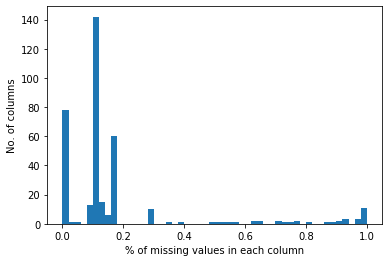

In [35]:
# plot a histogram to show the distribution of column NaN percentage in attributes
plt.hist(naCountsDf['na_percentage'],bins=50)
plt.xlabel('% of missing values in each column')
plt.ylabel('No. of columns')

In [36]:
# Remove columns with more than 200,000 missing values from the dataset.
azdias_rm_col = [index for index,value in enumerate(naCounts_by_column) if value/azdias.shape[0] > 0.35]
azdias_rm_col = azdias.columns[azdias_rm_col]
azdias_column_filtered = azdias.drop(azdias_rm_col, axis=1)
print(azdias_rm_col)
print('Number of columns that have more than 35% missing values: ',len(azdias_rm_col))
print(azdias_column_filtered.shape)

Index(['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM',
       'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM',
       'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
       'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM',
       'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM',
       'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'EXTSEL992', 'GEBURTSJAHR',
       'KBA05_BAUMAX', 'KBA13_ANZAHL_PKW', 'KK_KUNDENTYP', 'MIN_GEBAEUDEJAHR',
       'TITEL_KZ'],
      dtype='object')
Number of columns that have more than 35% missing values:  38
(891221, 327)


In [49]:
azdias_column_filtered

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,9.0,NaN,21.0,0.0,12.0,3.0,6.0,8A,8.0,51.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,9.0,17.0,17.0,0.0,7.0,3.0,2.0,4C,4.0,24.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,1.0,13.0,13.0,0.0,2.0,2.0,4.0,2A,2.0,12.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,1.0,20.0,14.0,0.0,3.0,4.0,2.0,6B,6.0,43.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,5.0,17.0,17.0,0.0,11.0,NaN,6.0,7A,7.0,41.0,...,2.0,4.0,7.0,8.0,3.0,4.0,3.0,4,2,3
891217,9.0,16.0,16.0,0.0,11.0,4.0,7.0,9D,9.0,51.0,...,4.0,6.0,9.0,6.0,6.0,9.0,5.0,6,1,2
891218,1.0,17.0,17.0,0.0,3.0,2.0,5.0,4C,4.0,24.0,...,2.0,7.0,10.0,8.0,NaN,5.0,7.0,4,2,2
891219,9.0,NaN,20.0,1.0,5.0,4.0,2.0,9D,9.0,51.0,...,4.0,9.0,8.0,5.0,1.0,9.0,5.0,5,1,1


In [51]:
#drop columns with more then 20 NaN
col_missing_value = azdias_column_filtered.columns[azdias_column_filtered.isnull().mean() >= 0.2]  
azdias_column_filtered = remove_col(azdias_column_filtered, col_missing_value)

In [53]:
row_missing_value = azdias_column_filtered.columns[azdias_column_filtered.isnull().mean() >= 0.3]
azdias_column_row_filtered = remove_col(azdias_column_filtered, row_missing_value)

In [54]:
azdias_column_row_filtered.shape

(891221, 316)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')